In [5]:
import torch
import torch.nn as nn
import re
from collections import Counter

class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, activation_func="ReLU"):
        super(NextWord, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)
        
        if activation_func == "ReLU":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.lin1(x))
        x = self.lin2(x)
        return x


In [6]:
from collections import Counter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open ("/kaggle/input/sirwala/temp.txt",'r') as data:
    text = data.read()

def preprocess_text(text):
    text = re.sub('\n', '.', text)
    text = re.sub('[^a-zA-Z0-9 /.]', '', text)

    text = text.lower()
    sentences = text.split('.')
    word_sequences = [sentence.strip().split() for sentence in sentences if sentence.strip()]
    return word_sequences

p_text = preprocess_text(str(text))
# Assume p_text is preprocessed text data (list of word sequences)
all_words = [word for sentence in p_text for word in sentence]
word_counts = Counter(all_words)
vocab = sorted(word_counts)
vocab_size = len(vocab)

# Word-to-index and index-to-word mappings
word_to_index = {word: idx for idx, word in enumerate(vocab)}
word_to_index["."] = 0
index_to_word = {idx: word for word, idx in word_to_index.items()}

def create_word_pairs(sequences, context_length, word_to_index):
    inputs, outputs = [], []

    for sentence in sequences:
        context = [word_to_index["."]] * context_length
        for word in sentence + ["."]:
            inputs.append([word_to_index.get(w, 0) for w in context])
            outputs.append(word_to_index.get(word, 0))
            context.pop(0)
            context.append(word)
    return inputs, outputs

# Convert word sequences to word-index sequences
inputs, outputs = create_word_pairs(p_text, context_length=4, word_to_index=word_to_index)

# Convert to tensors
X = torch.tensor(inputs).to(device)
Y = torch.tensor(outputs).to(device)


In [7]:
import torch.optim as optim

# Assume word_to_index and index_to_word mappings are defined
vocab_size = len(word_to_index)

# Hyperparameter settings to train different models
context_lengths = [4]
# context_lengths = [4, 8]
embedding_dims = [1024]
# embedding_dims = [256, 1024]
activation_funcs = ["ReLU"]
# activation_funcs = ["ReLU", "Softmax"]
random_seeds = [42]
# random_seeds = [42, 2024]
print_every = 2
device

device(type='cuda')

In [25]:

for context_length in context_lengths:
    for embedding_dim in embedding_dims:
        for activation_func in activation_funcs:
            for random_seed in random_seeds:
                # Set random seed for reproducibility
                torch.manual_seed(random_seed)
                
                # Define model
                model = NextWord(
                    block_size=context_length,
                    vocab_size=vocab_size,
                    emb_dim=embedding_dim,
                    hidden_size=10,
                    activation_func=activation_func
                )
                model = torch.nn.DataParallel(model,device_ids = [0,1]).to(device)

                # Define loss and optimizer
                loss_fn = nn.CrossEntropyLoss()
                optimizer = optim.AdamW(model.parameters(), lr=0.01)

                # Training loop (simplified)
                epochs = 50  # Train for 50 epochs
                batch_size = 4096

                for epoch in range(epochs):
                    model.train()
                    for i in range(0, X.shape[0], batch_size):
                        x_batch = X[i:i + batch_size]
                        y_batch = Y[i:i + batch_size]
                        
                        y_pred = model(x_batch)
                        loss = loss_fn(y_pred, y_batch)
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                    if epoch % print_every == 0:
                        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
                # Save the trained model with hyperparameter info in the filename
                model_path = f"/kaggle/working/model_{context_length}_{embedding_dim}_{activation_func}_{random_seed}.pth"
                torch.save(model.state_dict(), model_path)
                print(f"Model saved to {model_path}")
        # Convert word sequences to word-index sequences
#     inputs, outputs = create_word_pairs(p_text, context_length=8, word_to_index=word_to_index)

    # Convert to tensors
    X = torch.tensor(inputs).to(device)
    Y = torch.tensor(outputs).to(device)


Epoch 1, Loss: 6.511883735656738
Epoch 3, Loss: 5.901288032531738
Epoch 5, Loss: 5.593700408935547
Epoch 7, Loss: 5.405470848083496
Epoch 9, Loss: 5.280632495880127
Epoch 11, Loss: 5.199676513671875
Epoch 13, Loss: 5.137167453765869
Epoch 15, Loss: 5.088432788848877
Epoch 17, Loss: 5.044264793395996
Epoch 19, Loss: 5.004367351531982
Epoch 21, Loss: 4.967849254608154
Epoch 23, Loss: 4.935993194580078
Epoch 25, Loss: 4.904635429382324
Epoch 27, Loss: 4.8729376792907715
Epoch 29, Loss: 4.839873313903809
Epoch 31, Loss: 4.809009552001953
Epoch 33, Loss: 4.778814315795898
Epoch 35, Loss: 4.749936103820801
Epoch 37, Loss: 4.725372314453125
Epoch 39, Loss: 4.704392910003662
Epoch 41, Loss: 4.6833415031433105
Epoch 43, Loss: 4.665094375610352
Epoch 45, Loss: 4.649099349975586
Epoch 47, Loss: 4.635366916656494
Epoch 49, Loss: 4.622217178344727
Model saved to /kaggle/working/model_4_16_ReLU_42.pth


# Load model

In [8]:
def load_model(context_length, embedding_dim, activation_function, random_seed):
    model = NextWord(context_length,vocab_size,embedding_dim,128,activation_function).to(device)  ## change yaha hai
    # model = NextWord(context_length, len(word_to_index), embedding_dim, 10,activation_function).to(device)
    model_path = f"/kaggle/input/4_1024_r_42/pytorch/default/1/model_4_1024_ReLU_42.pth"
    # model.load_state_dict(torch.load(model_path, map_location=device))
    ## Error solved here
    state_dict = torch.load(model_path, map_location=device)

    # Check if keys have "module." prefix and remove it
    if list(state_dict.keys())[0].startswith("module."):
        state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

    # Load the modified state dictionary into the model
    model.load_state_dict(state_dict)
    return model

In [9]:
def generate_word(text, model, index_to_word, word_to_index, block_size, max_len=15):
    context = [word_to_index.get(w.lower(), 0) for w in text.split()]
    if len(context)<block_size:
        context = [0]*(block_size-len(context))+context
    else:
        context = context[:block_size]
    len(context)
    sentence = []
    print(context)
    for _ in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        # word = index_to_word.get(ix, ".")
        word = index_to_word[ix]
        context.pop(0)
        context.append(ix)
        # print(word)
        
        if word == '.':
            break
        sentence.append(word)
        context = context[1:] + [ix]
    

    return sentence

In [11]:
context_length=4
embedding_dim = 1024
activation_function = "ReLU"
random_seed=42
model = load_model(context_length, embedding_dim, activation_function, random_seed)

input_text = "I am a good"
predicted_sentence = generate_word(input_text, model, index_to_word, word_to_index, context_length)
    
    # Display predicted sentence
print(" ".join(predicted_sentence))

[8704, 650, 92, 7687]
in that turns closer but person attack


/tmp/ipykernel_30/1283670679.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


# Visualyze the embedding

In [12]:
# Get the embeddings from the embedding layer
embeddings = model.emb.weight.data.cpu().numpy()
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce embeddings to 2D
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)


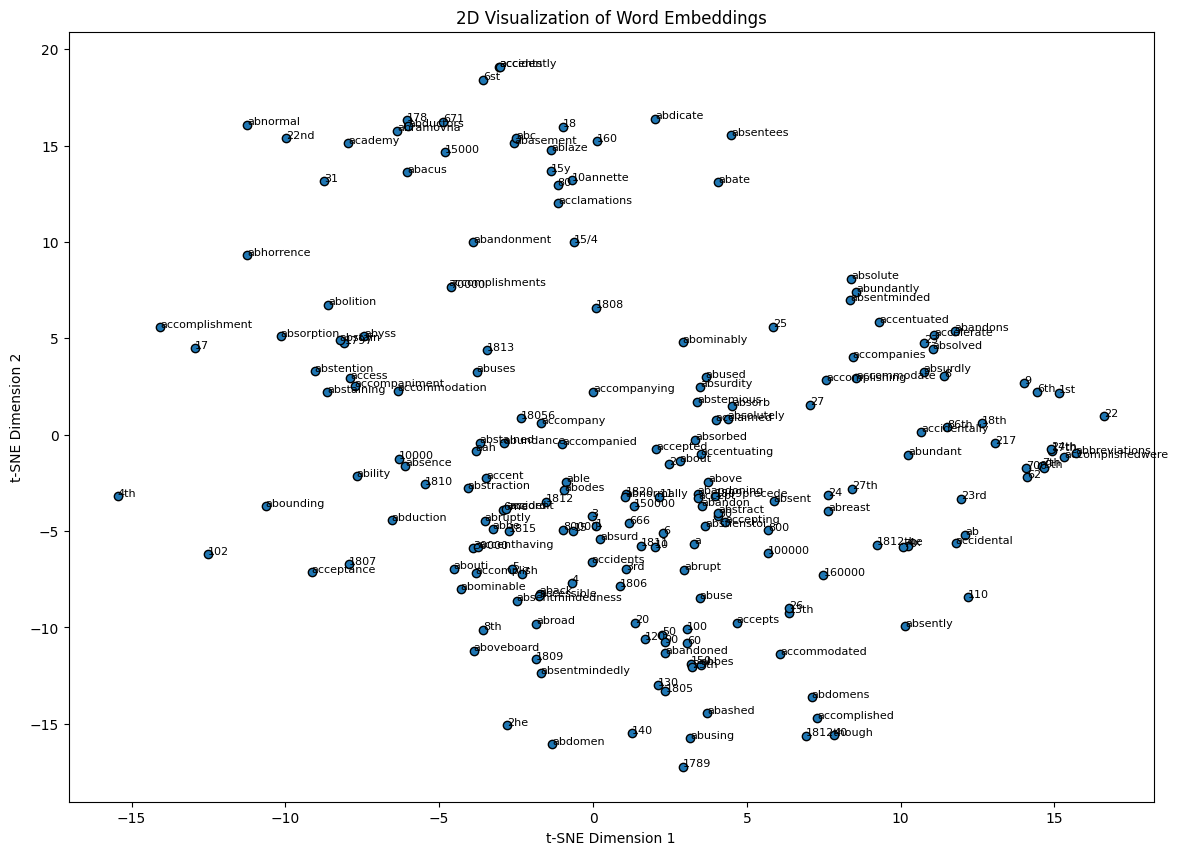

In [14]:
# Plotting the embeddings
plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:200, 0], embeddings_2d[:200, 1], marker='o', edgecolor='k')

# Annotate points with words
for i, word in enumerate(word_to_index):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)
    if i>200:
        break

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('2D Visualization of Word Embeddings')
plt.show()
